# Titanic - Machine Learning from Disaster

Kaggle has created a number of competitions designed for beginners. The most popular of these competitions, and the one we'll be looking at, is about predicting which passengers survived the sinking of the Titanic:

https://www.kaggle.com/c/titanic/overview

In this competition, we have a data set of different information about passengers onboard the Titanic, and we want to see if we can use that information to predict whether those people survived or not. 

In [1]:
import pandas as pd
test = pd.read_csv("titanic_test.csv")
train = pd.read_csv("titanic_train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Exploration

The data dictionary is given as follows:

| Variable | Definition | Key | Notes |
| :- | :- | :- | :- |
| survival | Survival | 0 = No, 1 = Yes 
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd | A proxy for socio-economic status, 1-Upper, 2-Middle, 3-Lower
| sex | Sex | 	
| Age | Age in years | Age is fractional if less than 1 | If the age is estimated, is it in the form of xx.5
| sibsp | # of siblings / spouses aboard the Titanic | | Spouse = husband, wife (mistresses and fiancés were ignored)
| parch | # of parents / children aboard the Titanic | | Some children travelled only with a nanny, therefore parch=0 for them.
| ticket | Ticket number |
| fare | Passenger fare |
| cabin | Cabin number |	
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton

The type of machine learning we will be doing is called classification, because when we make predictions we are classifying each passenger as a survivor or not. More specifically, we are performing binary classification, which means that there are only two different states we are classifying.

In any machine learning exercise, thinking about the topic you are predicting is very important. We call this step acquiring domain knowledge, and it's one of the most important determinants for success in machine learning.

In this case, understanding the Titanic disaster and specifically what variables might affect the outcome of survival is important. Anyone who has watched the movie Titanic would remember that women and children were given preference to lifeboats (as they were in real life). You would also remember the vast class disparity of the passengers.

This indicates that Age, Sex, and PClass may be good predictors of survival. We'll start by exploring Sex and Pclass by visualizing the data.

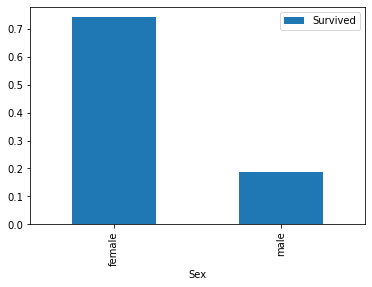

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()

We can immediately see that females survived in much higher proportions than males did. Let's do the same with the Pclass column:

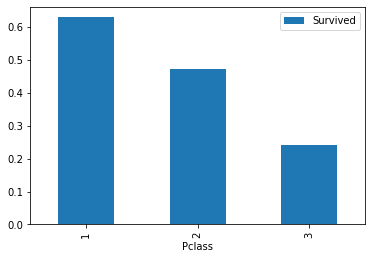

In [3]:
class_pivot = train.pivot_table(index="Pclass",values="Survived")
class_pivot.plot.bar()
plt.show()

Unsurprisingly, the upper class passengers were saved first regardless of sex or age as depicted in the movie.

The Age column needs to be treated slightly differently, as this is a continuous numerical column. One way to look at distribution of values in a continuous numerical set is to use histograms. We can create two histograms to compare visually those that survived vs those who died across different age ranges:

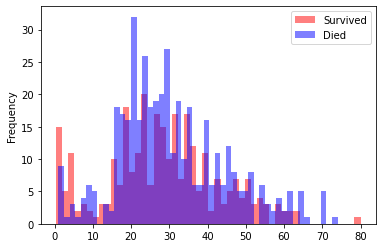

In [4]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

The relationship here is not simple, but we can see that in some age ranges (for example 0-5) more passengers survived. In order for this to be useful to our machine learning model, we can separate this continuous feature into a categorical feature by dividing it into ranges.

In [5]:
print(train["Age"].describe())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


We see that the Age column contains numbers ranging from 0.42 to 80.0 and that there are 714 values in this column, fewer than the total of 891 rows of the train data set. So there are some missing values we need to fill before dividing the data into categories:

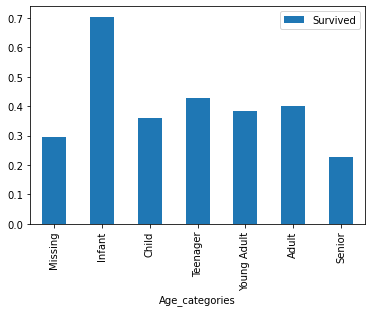

In [6]:
def process_age(df,cut_points,label_names):
    df['Age'] = df['Age'].fillna(-0.5)
    df['Age_categories'] = pd.cut(df['Age'],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ['Missing','Infant','Child','Teenager','Young Adult','Adult','Senior']

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

age_pivot = train.pivot_table(index='Age_categories',values='Survived')
age_pivot.plot.bar()
plt.show()

## Data Preparation

So far we have identified three columns that may be useful for predicting survival:
* Sex
* Pclass
* Age, or more specifically our newly created Age_categories

Before we build our model, we need to prepare these columns for machine learning. Most machine learning algorithms can't understand text labels, so we have to convert our values into numbers.

In [7]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")

train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")

train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   PassengerId                 891 non-null    int64   
 1   Survived                    891 non-null    int64   
 2   Pclass                      891 non-null    int64   
 3   Name                        891 non-null    object  
 4   Sex                         891 non-null    object  
 5   Age                         891 non-null    float64 
 6   SibSp                       891 non-null    int64   
 7   Parch                       891 non-null    int64   
 8   Ticket                      891 non-null    object  
 9   Fare                        891 non-null    float64 
 10  Cabin                       204 non-null    object  
 11  Embarked                    889 non-null    object  
 12  Age_categories              891 non-null    category
 13  Sex_female          

## Logistic Regression

We already have a test dataframe that we could use to make predictions, but because it doesn't have the Survived column we would have to submit it to Kaggle to find out our accuracy. This would quickly become a pain if we had to submit to find out the accuracy every time we optimized our model.

We could also fit and predict on our train dataframe, however if we do this there is a high likelihood that our model will overfit, which means it will perform well because we're testing on the same data we've trained on, but then perform much worse on new, unseen data.

Instead we can split our train dataframe into two:
* One part to train our model on (often 80% of the observations)
* One part to make predictions with and test our model (often 20% of the observations)

The convention in machine learning is to call these two parts train and test. This can become confusing, since we already have our test dataframe that we will eventually use to make predictions to submit to Kaggle. To avoid confusion, from here on, we're going to call this Kaggle 'test' data holdout data, which is the technical name given to this type of data used for final predictions.

In [8]:
holdout = test # from now on we will refer to this
               # dataframe as the holdout data

from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(
    all_X, all_y, test_size=0.2,random_state=0)

Now that we have our data split into train and test sets, we can fit our model again on our training set, and then use that model to make predictions on our test set.

There are a number of ways to measure the accuracy of machine learning models, but when competing in Kaggle competitions we need to use the same method that Kaggle uses to calculate accuracy for that specific competition.

In this case, the evaluation section for the Titanic competition on Kaggle tells us that our score calculated as "the percentage of passengers correctly predicted". This is by far the most common form of accuracy for binary classification.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
print(accuracy)

0.8100558659217877


Our model has an accuracy score of 81.0% when tested against our 20% test set. Given that this data set is quite small, there is a good chance that our model is overfitting, and will not perform as well on totally unseen data.

To give us a better understanding of the real performance of our model, we can use cross validation to train and test our model on different splits of our data, and then average the accuracy scores.

In [10]:
from sklearn.model_selection import cross_val_score
import numpy as np
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[0.8        0.82022472 0.76404494 0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80898876]
0.8024719101123596


From the results of our k-fold validation, you can see that the accuracy number varies with each fold - ranging between 76.4% and 87.6%. This demonstrates why cross validation is important.

As it happens, our average accuracy score was 80.2%, which is not far from the 81.0% we got from our simple train/test split. However this will not always be the case, so we need to always use cross-validation to make sure the error metrics are accurate.

In [11]:
# Make predictions based on holdout data

lr = LogisticRegression()
lr.fit(all_X, all_y)
holdout_predictions = lr.predict(holdout[columns])

The last thing we need to do is create a submission file. Each Kaggle competition can have slightly different requirements for the submission file. Here's what is specified on the Titanic competition evaluation page:
* You should submit a csv file with exactly 418 entries plus a header row. Your submission will show an error if you have extra columns (beyond PassengerId and Survived) or rows.
* The file should have exactly 2 columns:
    * PassengerId (sorted in any order)
    * Survived (contains your binary predictions: 1 for survived, 0 for deceased)

In [12]:
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

# submission.to_csv("submission.csv",index=False)

Submitting the predictions to Kaggle gives us the following accuracy:

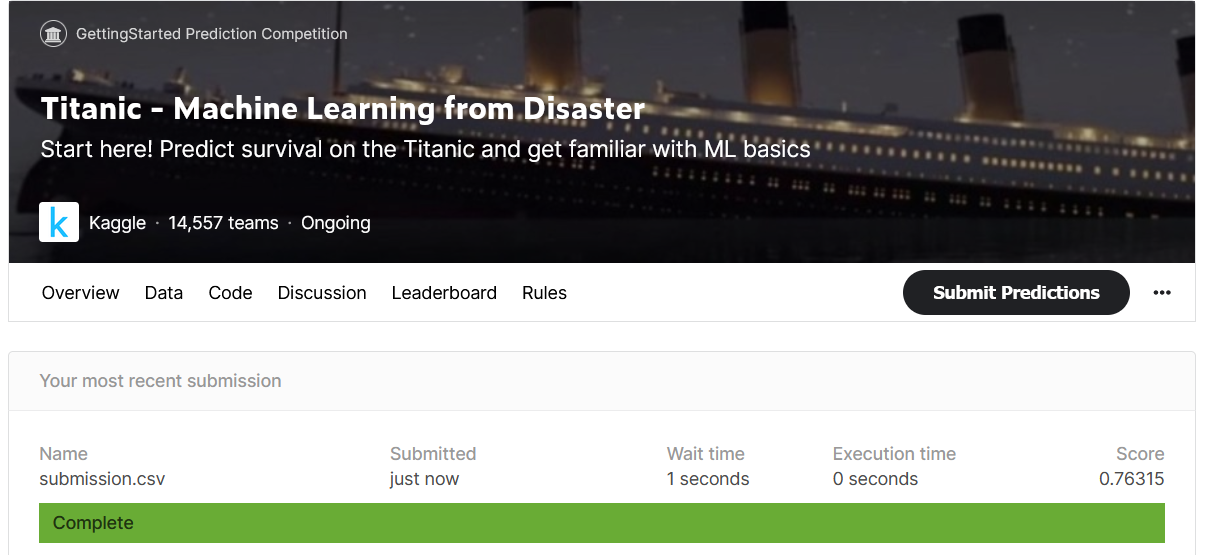

The fact that our accuracy on the holdout data is 76.3% compared with the 80.2% accuracy we got with cross-validation indicates that our model is overfitting slightly to our training data. It's also very common to see a small number of scores of 100% at the top of the Titanic leaderboard and think that you have a long way to go. In reality, anyone scoring about 90% on this competition is likely cheating (it's easy to look up the names of the passengers in the holdout set online and see if they survived).

There is a great analysis on Kaggle called "How am I doing with my score", which uses a few different strategies and suggests a minimum score for this competition is 62.7% (achieved by presuming that every passenger died) and a maximum of around 85%:

https://www.kaggle.com/pliptor/how-am-i-doing-with-my-score

We are a little over halfway between the minimum and maximum, which is a great starting point.

## Feature Selection

Feature selection is important because it helps to exclude features which are not good predictors, or features that are closely related to each other. Both of these will cause our model to be less accurate, particularly on previously unseen data.

In [13]:
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior'],
      dtype='object')


Our initial model was based on three columns from the original data: Age, Sex, and Pclass. As seen, there are a number of other columns that we haven't yet used. We can ignore PassengerId, since this is just a column Kaggle have added to identify each passenger and calculate scores. We can also ignore Survived, as this is what we're predicting, as well as the three columns we've already used.

At first glance, both the Name and Ticket columns look to be unique to each passenger. We will come back to these columns later, but for now we'll focus on the other columns.

In [14]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
print(train[columns].describe(include='all',percentiles=[]))

             SibSp       Parch        Fare Cabin Embarked
count   891.000000  891.000000  891.000000   204      889
unique         NaN         NaN         NaN   147        3
top            NaN         NaN         NaN    G6        S
freq           NaN         NaN         NaN     4      644
mean      0.523008    0.381594   32.204208   NaN      NaN
std       1.102743    0.806057   49.693429   NaN      NaN
min       0.000000    0.000000    0.000000   NaN      NaN
50%       0.000000    0.000000   14.454200   NaN      NaN
max       8.000000    6.000000  512.329200   NaN      NaN


In [15]:
print(holdout[columns].describe(include='all',percentiles=[]))

             SibSp       Parch        Fare            Cabin Embarked
count   418.000000  418.000000  417.000000               91      418
unique         NaN         NaN         NaN               76        3
top            NaN         NaN         NaN  B57 B59 B63 B66        S
freq           NaN         NaN         NaN                3      270
mean      0.447368    0.392344   35.627188              NaN      NaN
std       0.896760    0.981429   55.907576              NaN      NaN
min       0.000000    0.000000    0.000000              NaN      NaN
50%       0.000000    0.000000   14.454200              NaN      NaN
max       8.000000    9.000000  512.329200              NaN      NaN


Of these, SibSp, Parch and Fare look to be standard numeric columns with no missing values. Cabin has values for only 204 of the 891 rows, and even then most of the values are unique, so for now we will leave this column also. Embarked looks to be a standard categorical column with 3 unique values, much like PClass was, except that there are two missing values. We can easily fill these two missing values with the most common value, "S" which occurs 644 times.

Looking at our numeric columns, we can see a big difference between the range of each. SibSp has values between 0-8, Parch between 0-6, and Fare is on a dramatically different scale, with values ranging from 0-512. In order to make sure these values are equally weighted within our model, we'll need to rescale the data.

In [16]:
from sklearn.preprocessing import minmax_scale
# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

# Replace the 2 missing values in Embarked with the most common value
train['Embarked'] = train['Embarked'].fillna('S')
holdout['Embarked'] = holdout['Embarked'].fillna('S')

# Create dummy columns for the 3 unique values in Embarked
train = create_dummies(train,'Embarked')
holdout = create_dummies(holdout,'Embarked')

# Rescale the SibSp, Parch, and Fare columns
scale_cols = ['SibSp', 'Parch', 'Fare']

for col in scale_cols:
    train[col + '_scaled'] = minmax_scale(train[col])
    holdout[col + '_scaled'] = minmax_scale(holdout[col])

In order to select the best-performing features, we need a way to measure which of our features are relevant to our outcome - in this case, the survival of each passenger. One effective way is by training a logistic regression model using all of our features, and then looking at the coefficients of each feature.

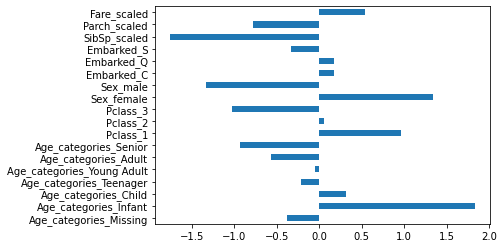

In [17]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

lr = LogisticRegression()
lr.fit(train[columns], train['Survived'])
coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0],
                               index=train[columns].columns)
feature_importance.plot.barh()
plt.show()

Whether the value is positive or negative isn't as important in this case, relative to the magnitude of the value. A feature that indicates strongly whether a passenger died is just as useful as a feature that indicates strongly that a passenger survived, given they are mutually exclusive outcomes.

To make things easier to interpret, we'll alter the plot to show all positive values, and have sorted the bars in order of size:

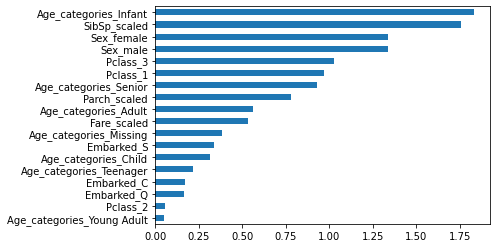

In [18]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

We'll train a new model with the top 8 scores and check the accuracy using cross validation.

In [19]:
from sklearn.model_selection import cross_val_score

columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

lr = LogisticRegression()
scores = cross_val_score(lr, train[columns], train['Survived'], cv=10)
accuracy = scores.mean()
print(accuracy)

0.8148064918851435


It seems like the cross validation score could be improved marginally to 81.48%. Hopefully, this improvement will translate to previously unseen data. Let's train a model using the columns from the previous step, make some predictions on the holdout data and submit it to Kaggle for scoring.

In [20]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
lr.fit(all_X, all_y)
holdout_predictions = lr.predict(holdout[columns])

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

#submission.to_csv("submission_1.csv",index=False)

When we submit it to Kaggle, the score is 77.75%, which is only a small improvement over 76.3%, but we're moving in the right direction.

## Feature Engineering

A lot of the gains in accuracy in machine learning come from Feature Engineering, which is the practice of creating new features from the existing data. One common way to engineer a feature is using a technique called binning. Binning is taking a continuous feature, like the fare a passenger paid for their ticket, and dividing it out into several ranges (or 'bins'), turning it into a categorical variable. This can be useful when there are patterns in the data that are non-linear and we're using a linear model like logistic regression.

We have already employed binning to the age column to create Age_categories. The same process can be applied to the Fare column.

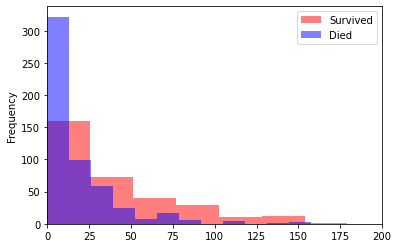

In [21]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Fare"].plot.hist(alpha=0.5,color='red',bins=20)
died["Fare"].plot.hist(alpha=0.5,color='blue',bins=20)
plt.legend(['Survived','Died'])
plt.xlim(0,200)
plt.show()

It looks like most passengers paid up to 100 pounds (assuming that was the currency), which means that we can first divide it into 2 groups(above and below 100). Within the below 100 group, there are a lot of passengers with 3rd class tickets with the prices below 12 and then there is another cluster below 50.

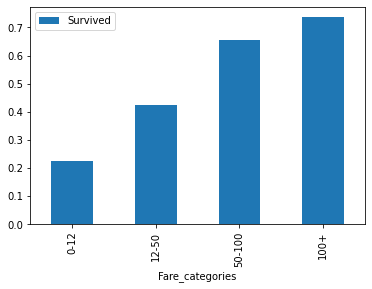

In [22]:
def process_fare(df,cut_points,label_names):
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

cut_points = [0,12,50,100,1000]
label_names = ['0-12','12-50','50-100','100+']

train = process_fare(train,cut_points,label_names)
holdout = process_fare(holdout,cut_points,label_names)

fare_pivot = train.pivot_table(index='Fare_categories',values='Survived')
fare_pivot.plot.bar()
plt.show()

As suspected, first class passengers (based on ticket prices) were saved at a much higher rate than the 3rd class passengers. It might be fiction, but in the movie Titanic, the 3rd class passengers were cruelly locked in the lower levels of the ship to stop the water from rising to the upper levels.

In [23]:
train = create_dummies(train,'Fare_categories')
holdout = create_dummies(holdout,'Fare_categories')

Another way to engineer features is by extracting data from text columns. Earlier, we decided that the Name and Cabin columns weren't useful by themselves, but what if there is some data there we could extract? Let's take a look at a random sample of rows from those two columns:

In [24]:
train[['Name', 'Cabin']].sample(7)

,Name,Cabin
81,"Sheerlinck, Mr. Jan Baptist",NaN
343,"Sedgwick, Mr. Charles Frederick Waddington",NaN
576,"Garside, Miss. Ethel",NaN
386,"Goodwin, Master. Sidney Leonard",NaN
484,"Bishop, Mr. Dickinson H",B49
71,"Goodwin, Miss. Lillian Amy",NaN
337,"Burns, Miss. Elizabeth Margaret",E40


While in isolation the cabin number of each passenger will be reasonably unique to each, we can see that the format of the cabin numbers is one letter followed by two numbers. It seems like the letter is representative of the type of cabin, which could be useful data for us. Looking at the Name column, There is a title like 'Mr' or 'Mrs' within each, as well as some less common titles, like the 'Rev.'. We can extract this information to create 2 new columns that we can categorize:

In [25]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)
extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

holdout["Cabin_type"] = holdout["Cabin"].str[0]
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")

for column in ["Title","Cabin_type"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)

In [26]:
train.select_dtypes(include=['float64', 'uint8']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         891 non-null    float64
 1   Fare                        891 non-null    float64
 2   Sex_female                  891 non-null    uint8  
 3   Sex_male                    891 non-null    uint8  
 4   Pclass_1                    891 non-null    uint8  
 5   Pclass_2                    891 non-null    uint8  
 6   Pclass_3                    891 non-null    uint8  
 7   Age_categories_Missing      891 non-null    uint8  
 8   Age_categories_Infant       891 non-null    uint8  
 9   Age_categories_Child        891 non-null    uint8  
 10  Age_categories_Teenager     891 non-null    uint8  
 11  Age_categories_Young Adult  891 non-null    uint8  
 12  Age_categories_Adult        891 non-null    uint8  
 13  Age_categories_Senior       891 non

We now have 36 possible feature columns(without the original Age and Fare columns) we can use to train our model. Before we move on with the model selection, we need to check collinearity, which occurs when more than one feature contains data that are similar. A common way to spot collinearity is to plot correlations between each pair of variables in a heatmap: 

<ipython-input-27-9af90d8992df>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


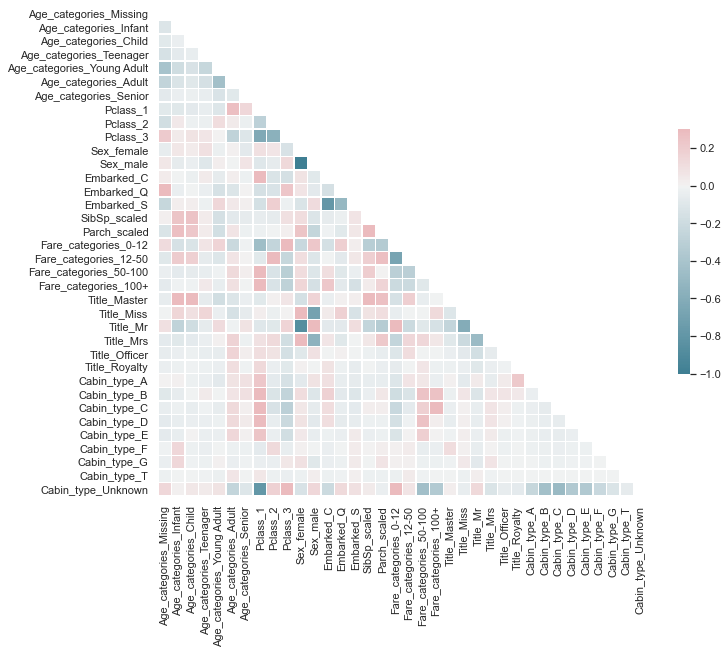

In [27]:
import numpy as np
import seaborn as sns

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

plot_correlation_heatmap(train[columns])

We can see that there is a high correlation between Sex_female/Sex_male and Title_Miss/Title_Mr/Title_Mrs. We will remove the columns Sex_female and Sex_male since the title data may be more nuanced.

Apart from that, we should remove one of each of our dummy variables to reduce the collinearity in each. We'll remove:
* Pclass_2
* Age_categories_Teenager
* Fare_categories_12-50
* Title_Master
* Cabin_type_A

In an earlier step, we manually used the logit coefficients to select the most relevant features. An alternate method is to use one of scikit-learn's inbuilt feature selection classes. We will be using the feature_selection.RFECV class which performs recursive feature elimination with the updated columns with cross-validation:

In [28]:
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]

lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(all_X,all_y)
optimized_columns = all_X.columns[selector.support_]
print(optimized_columns)

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')


Let's train a model using cross validation using these columns and check the score.

In [29]:
lr = LogisticRegression()
scores = cross_val_score(lr, train[optimized_columns], train["Survived"], cv=10)
accuracy = scores.mean()
print(accuracy)

0.8226591760299625


This four-feature model scores 82.3%, a modest improvement compared to the 81.5% from our earlier model. Let's train these columns on the holdout set, save a submission file and see what score we get from Kaggle.

In [30]:
all_X = train[optimized_columns]
all_y = train['Survived']

lr = LogisticRegression()
lr.fit(all_X, all_y)
holdout_predictions = lr.predict(holdout[optimized_columns])

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

#submission.to_csv("submission_2.csv",index=False)

The score this submission gets is 77.5%, which is marginally lower than the 77.75% we achieved with the previous submission, meaning there is still some work to be done for a meaningful improvement. We could for example:

* Use SibSp and Parch to explore total relatives onboard.
* Create combinations of multiple columns, for instance Pclass + Sex.
* Extract useful data out of the Ticket column.
* Try different combinations of features to see if we can identify features that overfit less than others.

However, selecting and optimizing different machine learning models could be more productive in improving the accuracy.

## Model Selection

We can try two new algorithms: k-nearest neighbors and random forests. Before doing that it's a good idea to save the modified datasets to new csv files to avoid modifying the original files.

In [31]:
#train.to_csv("train_modified.csv",index=False)
#holdout.to_csv("holdout_modified.csv",index=False)

In [32]:
train = pd.read_csv('train_modified.csv')
holdout = pd.read_csv('holdout_modified.csv')

To be able to compare algorithms, we can train the models based on all features using the whole train dataframe despite the collinearity problems discussed previously. So we have something to compare to, we're going to train a logistic regression model again to get a baseline score.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

all_X = train.drop(['Survived','PassengerId'],axis=1)
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy_lr = scores.mean()
print(accuracy_lr)

0.8249812734082397


Let's run K-neighbors classifier algorithm with varying k values from 1-49 to find which one results in the highest accuracy:

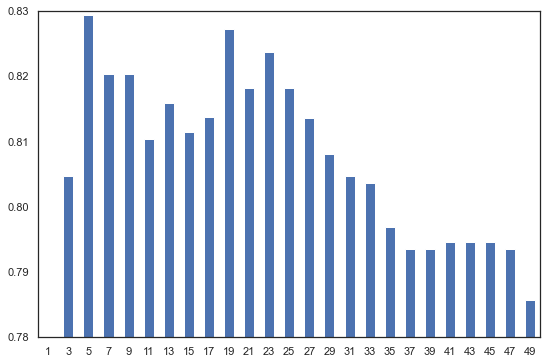

In [34]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),
                                   ylim=(0.78,0.83),rot=0)
    plt.show()

knn_scores = dict()
for k in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, all_X, all_y, cv=10)
    accuracy_knn = scores.mean()
    knn_scores[k] = accuracy_knn

plot_dict(knn_scores)

In [35]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

hyperparameters = {
    "n_neighbors": range(1,50,2)
}
grid = GridSearchCV(knn, param_grid=hyperparameters, cv=10)
grid.fit(all_X, all_y)

print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 5}
0.8293882646691635


It looks like the k-neighbors algorithm with 5 neighbors has improved the accuracy by 0.5% over the baseline. We can further test hyperparameters for the algorithm with the grid search:

In [36]:
hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid=hyperparameters, cv=10)
grid.fit(all_X, all_y)

print(grid.best_params_)
print(grid.best_score_)

{'algorithm': 'brute', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.8293882646691635


We can use these parameters to make predictions on the holdout dataset:

In [37]:
holdout_no_id = holdout.drop(['PassengerId'],axis=1)
best_knn = grid.best_estimator_
holdout_predictions = best_knn.predict(holdout_no_id)

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

#submission.to_csv("submission_3.csv",index=False)

This scores 75.4% on Kaggle, less than our best submission of 77.7% with logistic regression. While our model could be overfitting due to including all columns, it also seems like k-nearest neighbors may not be the best algorithm choice.

We can try Random Forest with the default parameters to see if it has potential:

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)
scores = cross_val_score(rf, all_X, all_y, cv=10)
accuracy_rf = scores.mean()
print(accuracy_rf)

0.8204119850187267


In [39]:
hyperparameters = {
    "criterion": ["entropy", "gini"],
    "max_depth": [5,10],
    "max_features": ["log2", "sqrt"],
    "min_samples_leaf": [1,5],
    "min_samples_split": [3,5],
    "n_estimators": [6,9]
}

grid = GridSearchCV(rf, param_grid=hyperparameters, cv=10)
grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_

print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 6}
0.838414481897628


The cross-validation score for the best performing model was 83.8%, making it the best algorithm we tested so far. We can test it on the holdout data and submit to Kaggle:

In [40]:
holdout_no_id = holdout.drop(['PassengerId'],axis=1)
best_rf = grid.best_estimator_
holdout_predictions = best_rf.predict(holdout_no_id)

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

# submission.to_csv("submission_4.csv",index=False)

This achieves a score of 76.8%, considerably better than our k-nearest neighbors score of 75.4% and close to our best score of 77.5%. Here is an overview of the model comparison:

| Model | Cross-Validation Score | Kaggle Score |
| :- | :-: | :-: |
| Logistic Regression with selected optimized features | 82.3 % | 77.5 % |
| Logistic Regression with all optimized features for baseline | 82.5 % | |
| K-nearest neighbors, best model from grid search | 82.9 % | 75.4 % |
| Random forests, best model from grid search | 83.8 % | 76.8 % |

By combining our strategies for feature selection, feature engineering, model selection and model tuning, we could continue to improve our score.

## Creating a Workflow

So far, we have worked on the data step by step from exploration to feature selection and then model selection. However we can create a reproducible workflow by combining all of these steps to help us iterate over ideas and continue to improve the accuracy of our predictions. Image taken from DataQuest:

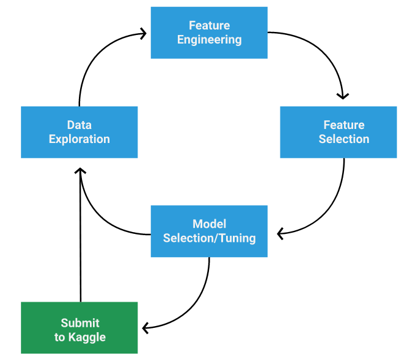

Kaggle Workflow:
* **Data exploration**, to find patterns in the data
* **Feature engineering**, to create new features from those patterns or through pure experimentation
* **Feature selection**, to select the best subset of our current set of features
* **Model selection/tuning**, training a number of models with different hyperparameters to find the best performer.

We can continue to repeat this cycle as we work to optimize our predictions. At the end of any cycle we wish, we can also use our model to make predictions on the holdout set and then **Submit to Kaggle** to get a leaderboard score.

For the individial steps, we can write helper functions which will make feature selection, model selection/tuning and creating submissions much easier as we continue to explore the data.

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)

Best Columns 
------------
['Pclass_3', 'Sex_female', 'Sex_male', 'Fare_scaled', 'Title_Mr']



Just like we did with feature selection, we can write a function to do the heavy lifting of model selection and tuning. The function we'll create will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

In [42]:
def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train,cols)

LogisticRegression
------------------
Best Score: 0.7889762796504369
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.8451310861423222
Best Parameters: {'algorithm': 'kd_tree', 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}

RandomForestClassifier
----------------------
Best Score: 0.8429213483146067
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 9}



We can achieve a cross-validation accuracy of 84.5% with k-neighbors algorithm when we use only the 5 best features that RFECV identified in the previous step. So we can make predictions with this "best" model to see if the Kaggle score improves. 

In [43]:
def save_submission_file(model,cols,filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

best_knn_model = result[1]["best_model"]
#save_submission_file(best_knn_model, cols, filename="submission_5.csv")

The chosen k-neighbors algorithm achieved a score of 76.6% on Kaggle, which is lower than the previous best. Finally, we can try the "best" model with random forest:

In [44]:
best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model, cols, filename="submission_6.csv")

The random forest algorithm with the chosen features only had 75.6 % accuracy on Kaggle. As mentioned previously, the Kaggle analysis "How am I doing with my score" suggests a maximum of around 85%. So there might be still room for improvement, however the tradeoff between time and accuracy for this particular small dataset does not seem to be favorable.

## Conclusions

Using the datasets from the Kaggle competition "Titanic - Machine Learning from Disaster", we were able to develop a workflow including the necessary steps from data exploration to model selection in order to come up with the most accurate machine learning model. While we only achieved the 4273rd position on the leaderboard with an accuracy of 77.5 %, this easy to understand dataset has given the opportunity to test the different methods we have learned and develop functions that can be useful for other projects.